## Trabalho Autoencoders

Prof: Paulo Cotta

Data de entrega: 09/12/2020

Nota: 30 pts

#### Roteiro do trabaho

- O trabalho deve ser explicado célula por célula
- Não é necessário chegar em um processo ótimo, o razoável já é muito bom
- O trabalho deve ser feito usando o modelo não supervisionado Autoencoder
- Havendo dúvida, pode perguntar ao professor, em qualquer horário que for necessário

#### Alunos
- João Marcelo
- Matheus Reis
- Matheus Sena
- Thiago Costa
- Ygor Oliveira

### O que deve ser feito

####  Recomendação de Conteúdo com Filtragem Colaborativa

O princípio da Filtragem Colaborativa é utilizar a informação das interações que ocorrem entre os usuários e os conteúdos para que, de forma coletiva, essa informação seja útil para inferir as preferências dos indivíduos.

O que devemos fazer é criar um modelo que seja capaz de gerar Scores dos determinados produtos que possam recomendar para os usuários. Exemplo dessa funcionalidade é recomendações do Netfix, Amazon, Google Maps e entre outros.

O dataset está contido na pasta [data], avaliem às variáveis.

OBS.: Pode usar códigos da internet e fique a vontade para pesquisar mais sobre Autoencoders.

### Imports

In [16]:
# imports

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session

In [2]:
tf.__version__

'2.2.0'

### Dataset

In [3]:
# dataset com dados dos jogos e o total de horas e jogadores
articles_df = pd.read_csv('./data/articles_df.csv')
articles_df.head()

,content_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9
4,4,"10,000,000",1,4.6


In [4]:
# quantidade de horas jogadas (ou só comprado quando horas == 1) por jogador
interactions_full_df = pd.read_csv('./data/interactions_full_df.csv')
interactions_full_df.head()

,user_id,content_id,game,hours,view
0,0,226,Alien Swarm,5.9,1
1,0,846,Cities Skylines,145.0,1
2,0,972,Counter-Strike,1.0,1
3,0,978,Counter-Strike Source,1.0,1
4,0,1125,Day of Defeat,1.0,1


In [5]:
# Top 5 jogadores com mais horas
interactions_full_df.sort_values('hours', ascending=False).head(5)

,user_id,content_id,game,hours,view
69958,1627,1328,Dota 2,10443.0,1
83764,2079,1328,Dota 2,7766.0,1
37124,852,1328,Dota 2,6965.0,1
62122,1398,1328,Dota 2,6016.0,1
52203,1154,3792,Sid Meier's Civilization V,6014.0,1


In [6]:
# Quantidade de horas jogadas por jogador ou jogo apenas adquirido
rating = pd.read_csv('./data/rating.csv', names=['user_id', 'game', 'type', 'hours', 'none'])
rating.head()

,user_id,game,type,hours,none
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [7]:
# dataset de treino e de test
df_train = pd.read_csv('./data/interactions_train_df.csv')
df_test = pd.read_csv('./data/interactions_test_df.csv')

### Construção dos dados

In [8]:
# matriz de correlação entre jogadores e jogos jogados
dataset = pd.pivot(df_train, index='user_id', columns='content_id', values='view')
dataset.fillna(0, inplace=True)
print(f'Shape do dataset de treino {dataset.shape}')

Shape do dataset de treino (3757, 4862)


In [9]:
x_train = dataset.values
y_train = dataset.values

In [10]:
# tipos de valores no dataset
dataset.describe()

content_id,0,1,2,3,5,6,7,8,9,10,...,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112
count,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,...,3757.000000,3757.000000,3757.000000,3757.000000,3757.000000,3757.00000,3757.000000,3757.000000,3757.000000,3757.000000
mean,0.000266,0.000266,0.001331,0.001065,0.002129,0.000532,0.002662,0.002928,0.001331,0.002396,...,0.000266,0.001065,0.000532,0.005323,0.000266,0.01943,0.000266,0.002928,0.044983,0.000532
std,0.016315,0.016315,0.036461,0.032616,0.046102,0.023069,0.051530,0.054038,0.036461,0.048892,...,0.016315,0.032616,0.023069,0.072777,0.016315,0.13805,0.016315,0.054038,0.207294,0.023069
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Model

In [11]:
clear_session()

In [12]:
model = Sequential(name='autoencoder')

# camada de entrada
model.add(Input((4862,)))
model.add(Dense(512, activation='selu'))
model.add(Dense(256, activation='selu'))
model.add(Dropout(0.8))

# camada de saída
model.add(Dense(512, activation='selu'))
model.add(Dense(4862, activation='linear'))

In [13]:
# compilando o modelo
model.compile(optimizer=Adam(lr=0.0001), loss='mse')

In [14]:
# desenho do modelo
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2489856   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 4862)              2494206   
Total params: 5,246,974
Trainable params: 5,246,974
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [15]:
history = model.fit(x=x_train, y=y_train,
                    epochs=50,
                    shuffle=True,
                    validation_split=0.1)

Epoch 1/50
106/106 [==============================] - 4s 36ms/step - loss: 0.0251 - val_loss: 0.0033
Epoch 2/50
106/106 [==============================] - 4s 39ms/step - loss: 0.0150 - val_loss: 0.0027
Epoch 3/50
106/106 [==============================] - 4s 40ms/step - loss: 0.0108 - val_loss: 0.0024
Epoch 4/50
106/106 [==============================] - 4s 35ms/step - loss: 0.0087 - val_loss: 0.0022
Epoch 5/50
106/106 [==============================] - 3s 32ms/step - loss: 0.0074 - val_loss: 0.0021- ETA:
Epoch 6/50
106/106 [==============================] - 3s 32ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 7/50
106/106 [==============================] - 3s 32ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 8/50
106/106 [==============================] - 4s 33ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 9/50
106/106 [==============================] - 4s 40ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 10/50
106/106 [==============================] - 4s 37ms/step - loss: 0.0053 - 

### Métricas do treinamento

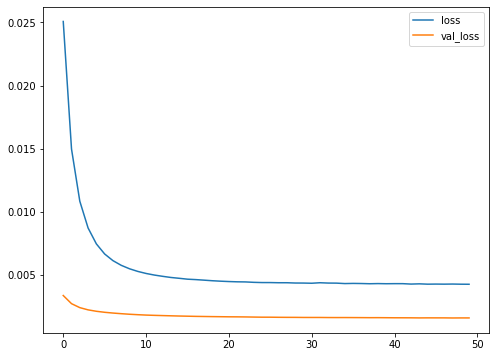

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')

ax.legend()
plt.show()

### Sistema de recomendação

In [33]:
matriz_recomendacao = model.predict(x_train)
matriz_recomendacao = pd.DataFrame(matriz_recomendacao, index=dataset.index, columns=dataset.columns)

In [56]:
def recomendacao(id_usuario, matriz_recomendacao, matriz_jogos, k=5):
    # scores do jogador 
    usuario_jogos_recomendacao = matriz_recomendacao.loc[id_usuario].values
    
    # dataset com jogador, jogo e score em ordem de melhor recomendação
    usuario_jogos_recomendacao_scores = pd.DataFrame({'score': usuario_jogos_recomendacao},
                                                     index=list(matriz_recomendacao.columns))
    usuario_jogos_recomendacao_scores = usuario_jogos_recomendacao_scores.join(matriz_jogos['game'])
    usuario_jogos_recomendacao_scores = usuario_jogos_recomendacao_scores.sort_values('score', ascending=False)
    
    return usuario_jogos_recomendacao_scores.head(k)

### Resultados

###### O jogador 1200 gosta de jogar jogos com história medieval, o que condiz com a recomendação

In [72]:
# jogos que ele joga
interactions_full_df[interactions_full_df['user_id'] == 1200].head(5)

,user_id,content_id,game,hours,view
53749,1200,173,Age of Empires II HD Edition,11.3,1
53750,1200,174,Age of Empires II HD The Forgotten,1.0,1
53751,1200,275,Anno 1404,25.0,1
53752,1200,276,Anno 1404 Venice,36.0,1
53753,1200,440,Banished,36.0,1


In [62]:
# jogos recomendados
recomendacao(1200, matriz_recomendacao, articles_df)

,score,game
4328,0.594614,The Elder Scrolls V Skyrim
4329,0.436620,The Elder Scrolls V Skyrim - Dawnguard
4330,0.423038,The Elder Scrolls V Skyrim - Dragonborn
4331,0.420610,The Elder Scrolls V Skyrim - Hearthfire
1667,0.418422,Fallout New Vegas


###### O jogador 3700 gosta de jogar jogos de FPS, o que condiz com a recomendação

In [73]:
# jogos que ele joga
interactions_full_df[interactions_full_df['user_id'] == 3700].head(5)

,user_id,content_id,game,hours,view
114655,3700,418,BLOCKADE 3D,1.0,1
114656,3700,975,Counter-Strike Global Offensive,71.0,1
114657,3700,976,Counter-Strike Nexon Zombies,2.0,1
114658,3700,1679,Far Cry 3,4.9,1
114659,3700,1886,Gear Up,1.0,1


In [70]:
# jogos recomendados
recomendacao(3700, matriz_recomendacao, articles_df)

,score,game
975,0.454469,Counter-Strike Global Offensive
4750,0.424096,Unturned
4221,0.155830,Team Fortress 2
1328,0.142575,Dota 2
976,0.127830,Counter-Strike Nexon Zombies
